In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Practice1/

/content/drive/My Drive/Practice1


torch.Size([10, 3, 32, 32])


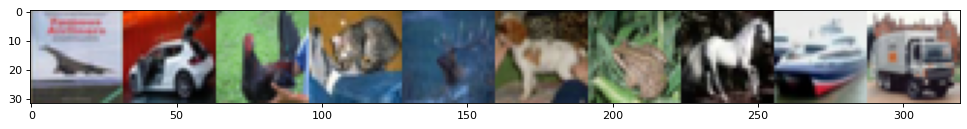

In [30]:
# load test data
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with open("/content/drive/My Drive/Practice1/imgs.pkl", "rb") as f:
    imgs = pickle.load(f)

mean = np.array([0.4913999, 0.48215866, 0.44653133])
std = np.array([0.24703476, 0.24348757, 0.26159027])

plt.figure(figsize=(15, 3), dpi=80)
base = np.zeros([32, 32*10, 3], dtype=np.uint8)
print(imgs.size())
for i in range(10):
    data = imgs[i].transpose(0,1).transpose(1,2).numpy()
    data = (data * std + mean)*255
    data = data.astype(np.uint8)
    base[:, 32*i:32*(i+1), :] = data
plt.imshow(base)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [31]:
# load model and pre-trained weight
import torch
from resnet import ResNet18, Pool

model = ResNet18(10)
model.load_state_dict(torch.load("r18_c10.pth"))
model.eval()

# store (module, input_activation, output_activation) pairs
module_io = []

def forward_hook(module, input, output):
    module_io.append((module, input[0].detach().numpy(), output.detach().numpy()))


hooks = []
for name, module in model.named_modules():
    #print(name)
    if isinstance(module, (torch.nn.Conv2d, torch.nn.BatchNorm2d, torch.nn.Linear, torch.nn.ReLU, Pool)):
        module.name = name
        #print(module, module.name)
        hooks.append(module.register_forward_hook(forward_hook))

output = model(imgs)

for hook in hooks:
    hook.remove()

#print(module_io)
# check the output class
print(torch.argmax(output, dim=0))

<ipython-input-31-fe61c04f3242>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("r18_c10.pth"))


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [39]:
# create your own custom kernel
import numpy as np

# input : B x C_i x H_i x W_i
# weight: C_o x C_i x H_k x W_k
# stride: (H_s, W_s)
# padding: (H_p, W_p)
# output: B x C_o x H_o x W_o (Note: check https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html for H_o and W_o)
def custom_full_conv(input, weight, stride, padding):

    # 파라미터 초기화 
    B, C_i, H_i, W_i = input.shape
    C_o, C_i, H_k, W_k = weight.shape
    H_s, W_s = stride
    H_p, W_p = padding

    H_o = (H_i + 2*H_p - H_k)//H_s + 1
    W_o = (W_i + 2*W_p - W_k)//W_s + 1

    # 패딩 적용
    input_padded = np.pad(input, ((0,0), (0,0), (H_p,H_p), (W_p,W_p)), mode='constant')

    # 출력 초기화
    output = np.zeros((B, C_o, H_o, W_o))

    # 연산
    for b in range(B):
        for c_o in range(C_o):
            for h_o in range(H_o):
                for w_o in range(W_o):
                    h_start = h_o * H_s
                    h_end = h_start + H_k
                    w_start = w_o * W_s
                    w_end = w_start + W_k

                    input_slice = input_padded[b, :, h_start:h_end, w_start:w_end]
                    output[b, c_o, h_o, w_o] = np.sum(input_slice * weight[c_o, :, :, :])

    return output
    

# input : B x C x H x W
# mean: C
# variance: C
# gamma: C
# beta: C
# eps: 1 (scalar)
# output: B x C x H x W
def custom_bn(input, mean, variance, gamma, beta, eps):

    # 파라미터 초기화
    B, C, H, W = input.shape

    # 각 채널 정규화 적용
    input_normalized = (input - mean.reshape(1, C, 1, 1)) / np.sqrt(variance.reshape(1, C, 1, 1) + eps)

    # 출력 연산
    output = gamma.reshape(1, C, 1, 1) * input_normalized + beta.reshape(1, C, 1, 1)

    return output


# input : B x C x H x W
# output: B x C x H x W
def custom_relu(input):

    # 활성함수 적용
    return np.maximum(0, input)


# input: B x C x H x W
# output: B x C
def custom_pool(input):

    # 파라미터 초기화
    B, C, H, W = input.shape

    # 출력 초기화
    output = np.zeros((B, C))

    # 출력 연산 (Global Max Pooling) -> Output이 B x C 이므로
    for b in range(B):
        for c in range(C):
            output[b, c] = np.max(input[b, c, :, :])

    return output

# input : B x C_i
# weight: C_o x C_i
# bias: C_o
# output: B x C_o
def custom_linear(input, weight, bias):
    B, C_i = input.shape
    C_o, C_i = weight.shape
    # print("input shape", input.shape, input)
    # print("weight shape", weight.shape, weight)
    for n in range(B):
        for o in range(C_o):
            for i in range(C_i):
                output[n,o] += input[n,i]*weight[o,i] + bias[o]
    return output

In [38]:
# test the implementation
for (module, input, output) in module_io:
    # single image inference for fast test
    #input = np.expand_dims(input[0], 0)
    #output = np.expand_dims(output[0], 0)

    if isinstance(module, torch.nn.Linear):
        out = custom_linear(input,
                            module.weight.data.numpy(),
                            module.bias.data.numpy())


        diff = np.linalg.norm(out - output)

        if diff > 1e-3:
            print(f"module {module.name} has large error {diff}")
        else:
            print(f"module {module.name} has good implemetation")


input shape (10, 512) [[0.22294708 0.80955255 0.         ... 0.         1.1058629  1.352085  ]
 [0.15702711 0.         0.82794297 ... 0.2910467  0.2213195  0.00778453]
 [0.6857558  0.4294486  0.27311844 ... 0.34463453 0.26019868 0.30277175]
 ...
 [0.08031847 0.88670206 0.48389098 ... 0.9040039  0.06347093 0.6468656 ]
 [0.00964529 0.         0.         ... 0.         0.93242383 0.95105267]
 [0.         0.         1.6845095  ... 0.14178732 0.2469066  0.6398527 ]]
weight shape (10, 512) [[ 0.08063114  0.08219915 -0.06387086 ... -0.17036171  0.08875375
   0.12941459]
 [-0.00471436 -0.06858657  0.1454282  ... -0.08204849 -0.06940646
  -0.15591274]
 [-0.07720799  0.24033308  0.00751985 ... -0.12084677 -0.06982914
   0.00284517]
 ...
 [-0.20896277  0.04308688  0.08178924 ...  0.12088298  0.01684218
   0.09543445]
 [-0.11197761 -0.06282344 -0.08079404 ... -0.14466035  0.06622532
   0.14402872]
 [-0.02523791 -0.02714766  0.14669433 ... -0.08631311  0.00566506
   0.09323565]]
module linear has g

In [34]:
# test the implementation
for (module, input, output) in module_io:
    # single image inference for fast test
    #input = np.expand_dims(input[0], 0)
    #output = np.expand_dims(output[0], 0)

    if isinstance(module, torch.nn.Conv2d):
        continue
        out = custom_full_conv(input,
                               module.weight.data.numpy(),
                               module.stride,
                               module.padding)
    elif isinstance(module, torch.nn.BatchNorm2d):
        out = custom_bn(input,
                        module.running_mean.data.numpy(),
                        module.running_var.data.numpy(),
                        module.weight.data.numpy(),
                        module.bias.data.numpy(),
                        module.eps)
    elif isinstance(module, torch.nn.ReLU):
        out = custom_relu(input)
    elif isinstance(module, Pool):
        out = custom_pool(input)
    elif isinstance(module, torch.nn.Linear):
        out = custom_linear(input,
                            module.weight.data.numpy(),
                            module.bias.data.numpy())
    else:
        raise NotImplementedError

    diff = np.linalg.norm(out - output)

    if diff > 1e-3:
        print(f"module {module.name} has large error {diff}")
    else:
        print(f"module {module.name} has good implemetation")


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'